# 0.0. IMPORTS

In [248]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import warnings
import inflection
import seaborn as sns
import xgboost as xgb

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

## 0.1. Helper functions

In [281]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 15
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set
    

In [250]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading data

In [6]:
df_housing_raw = pd.read_csv('../data/housing.csv', low_memory= False)

In [7]:
df_housing_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


# 1.0. DATA DESCRIPTION

In [8]:
df1 = df_housing_raw.copy()

## 1.1. Data dimensions

In [9]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 20640
Number of columns: 10


## 1.2. Data types

In [10]:
df1.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


In [11]:
df1.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

## 1.3. Check NA

In [12]:
df1.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

## 1.4. Filout NA

In [13]:
df1['total_bedrooms'] = df1['total_bedrooms'].apply( lambda x: 537.9 if math.isnan( x ) else x )

In [14]:
df1.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

## 1.5. Chenge data types

In [15]:
df1.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

## 1.6. Descriptive statistics

In [16]:
num_attributes = df1.select_dtypes(include = ['float64'])
cat_attributes = df1.select_dtypes(exclude = ['float64'])

### 1.6.1. Numerical attributes

In [17]:
# medidas de tendência central - mean and median

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


# medidas de dispersão - std, min, max, range, skew, kurtosis

md1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
md2 = pd.DataFrame( num_attributes.apply( min ) ).T 
md3 = pd.DataFrame( num_attributes.apply( max ) ).T 
md4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
md5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
md6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

#concatenar

medidas = pd.concat([ct1, ct2, md2, md3, md1, md4, md5, md6 ]).T.reset_index()
medidas.columns = ['attributes', 'mean', 'median', 'min', 'max', 'std', 'range', 'skew', 'kurtosis' ]

In [18]:
medidas

,attributes,mean,median,min,max,std,range,skew,kurtosis
0,longitude,-119.569704,-118.4900,-124.3500,-114.3100,2.003483,10.0400,-0.297801,-1.330152
1,latitude,35.631861,34.2600,32.5400,41.9500,2.135901,9.4100,0.465953,-1.117760
2,housing_median_age,28.639486,29.0000,1.0000,52.0000,12.585253,51.0000,0.060331,-0.800629
3,total_rooms,2635.763081,2127.0000,2.0000,39320.0000,2181.562402,39318.0000,4.147343,32.630927
4,total_bedrooms,537.870848,438.0000,1.0000,6445.0000,419.256436,6444.0000,3.477021,22.238633
5,population,1425.476744,1166.0000,3.0000,35682.0000,1132.434688,35679.0000,4.935858,73.553116
6,households,499.539680,409.0000,1.0000,6082.0000,382.320491,6081.0000,3.410438,22.057988
7,median_income,3.870671,3.5348,0.4999,15.0001,1.899776,14.5002,1.646657,4.952524
8,median_house_value,206855.816909,179700.0000,14999.0000,500001.0000,115392.820404,485002.0000,0.977763,0.327870


In [19]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20640.0,537.870848,419.266592,1.0000,297.0000,438.0000,643.25000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


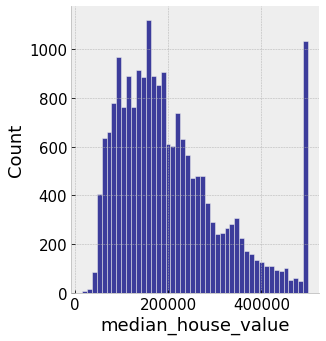

In [20]:
sns.displot( df1['median_house_value'], color='navy' );

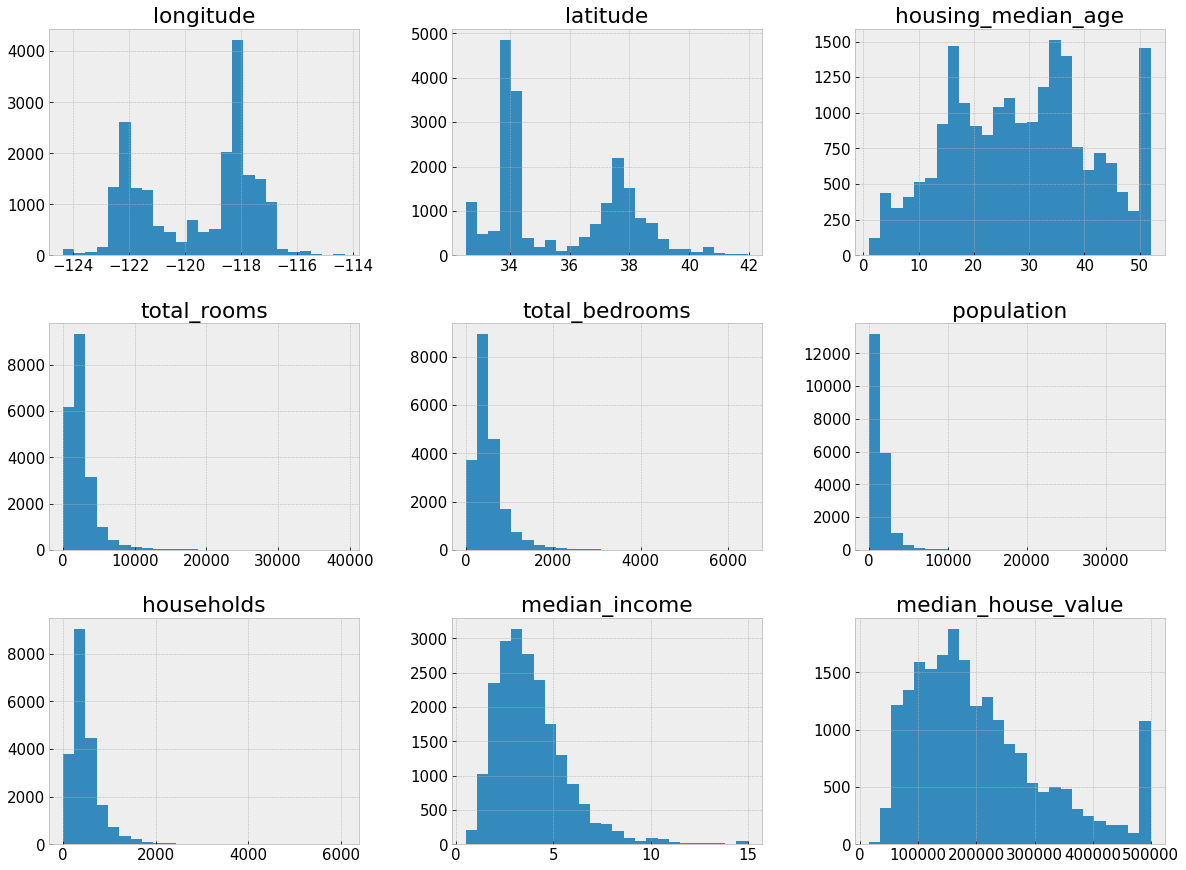

In [21]:
df1.hist(bins=25, figsize=(20, 15));

### 1.6.2. Categorical attributes

In [22]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

ocean_proximity    5
dtype: int64

In [23]:
cat_attributes.value_counts()

ocean_proximity
<1H OCEAN          9136
INLAND             6551
NEAR OCEAN         2658
NEAR BAY           2290
ISLAND                5
dtype: int64

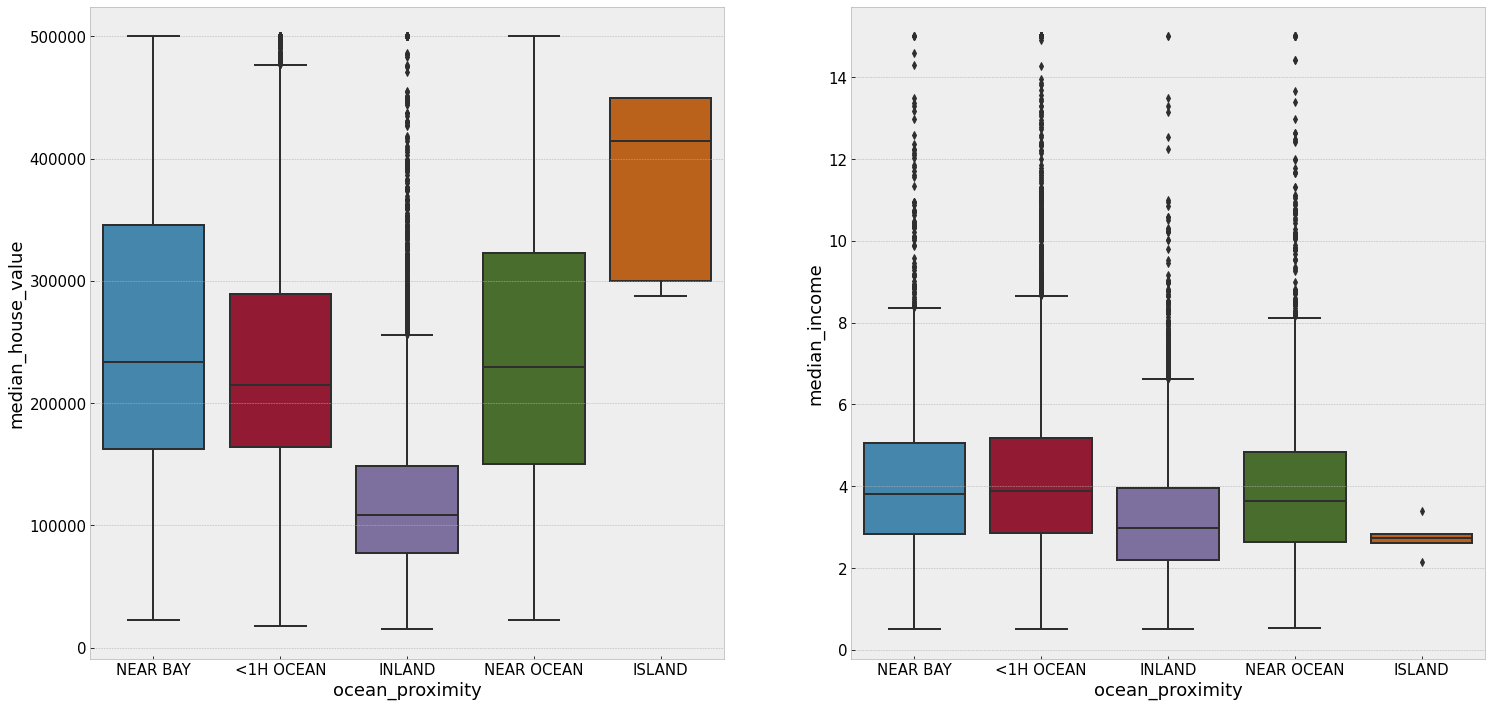

In [24]:
plt.subplot( 1, 2, 1 );
sns.boxplot( x='ocean_proximity', y='median_house_value', data=df1 );

plt.subplot( 1, 2, 2 );
sns.boxplot( x='ocean_proximity', y='median_income', data=df1 );


# 2.0. FEATURE ENGINEERING

In [25]:
df2 = df1.copy()

## 2.1. Mapa mental de hipóteses

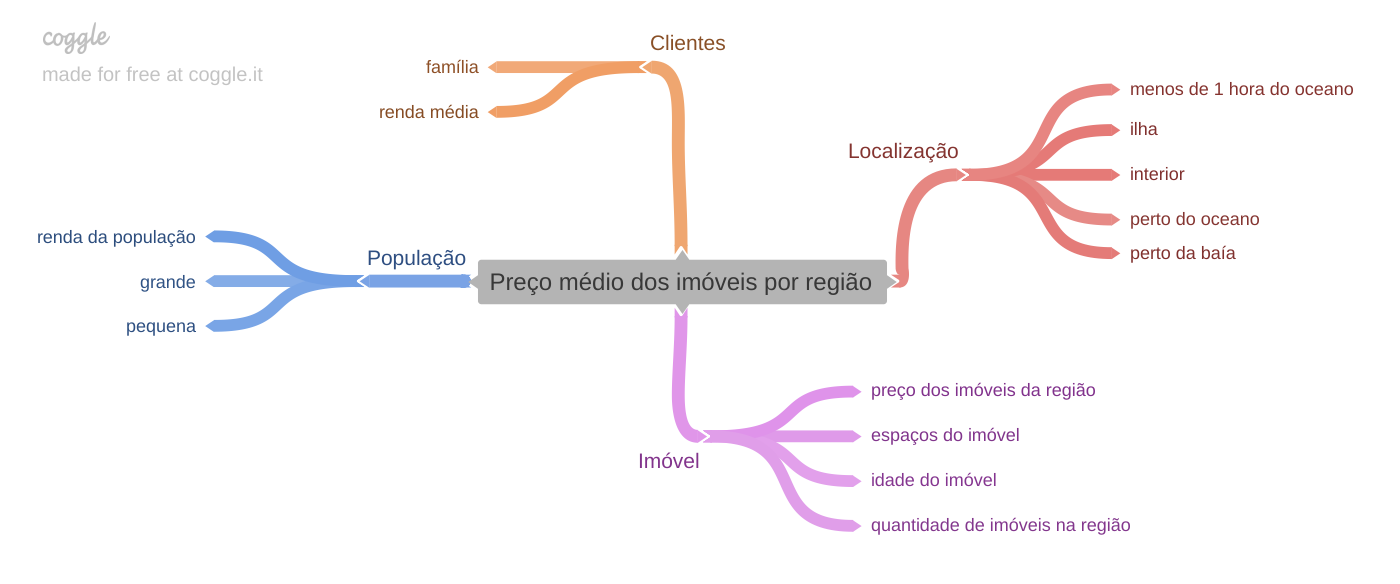

In [26]:
Image('../img/mind_map.png')

## 2.2. Criação das hipóteses

### 2.2.1.  Hipóteses clientes

**1.** Clientes com maior renda compram imóveis mais caros
</br>
**2.** Clientes com maiores famílias compram os maiores imóveis
</br>
**3.** Clientes que comparam imóveis no interior possuem maiores família
</br>
**4.** Clientes com maiores famíllias preferem imóveis com maior número de quartos
</br>
**5.** Clientes com maior renda compram imóveis menores
</br>
**6.** Clientes com maior renda compram imóveis mais novos
</br>
**7.** Clientes com menor renda compram mais antigos
</br>
**8.** Clientes com maiores famílias compram imóveis mais caros

### 2.2.2.  Hipóteses Localização 

**1.** Imóveis localizados à menos de 1 hora do oceano são mais vendidos  
</br>
**2.** Imóveis localizados em ilhas são costumam ser mais caros
</br>
**3.** Imóveis localizados no interior são mais baratos
</br>
**4.** Imóveis perto do oceano são vendidos para clientes com maior renda

### 2.2.3.  Hipóteses Imóveis

**1.** Imóveis à menos de 1 hora do oceano possuem menor número de cômodos
</br>
**2.** Imóveis à menos de 1 hora do oceano são mais caros
</br>
**3.** Imóveis no interior são comprados por cleintes que possuem menor renda
</br>
**4.** Imóveis localizados perto da baía costuma atrair clientes com maior renda
</br>
**5** Imóveis mais antigos são mais baratos
</br>
**6** Imóveis maiores possuem maior valor
</br>
**7** Imóveis menores costumam ser mais baratos 
</br>
**8** Imóveis mais caros são vendidos na ilha 
</br>
**9** Imóveis mais baratos são vendidos para maiores famílias

### 2.2.4.  Hipóteses População

**1.** Lugares mais populosos possuem imóveis mais baratos
</br>
**2.** Lugares mais populosos possuem clientes com maiores renda
</br>
**3.** Lugares mais menos populosos possuem imóveis mais caros
</br>
**4.** Lugares menos populosos possuem clientes com maiores renda

### 2.2.4. Lista final de hipóteses

**1.** Clientes com maior renda compram imóveis mais caros
</br>
**2.** Clientes com maiores famílias compram imóveis mais baratos
</br>
**3.** Clientes com maior renda compram imóveis mais novos
</br>
**4.** Clientes com menor renda compram mais antigos
</br>
**5.** Imóveis localizados à menos de 1 hora do oceano são mais vendidos  
</br>
**6.** Imóveis mais baratos são vendidos para maiores famílias
</br>
**7.** Imóveis localizados em ilhas são costumam ser mais caros
</br>
**8.** Imóveis localizados no interior são mais baratos
</br>
**9.** Imóveis perto do oceano são vendidos para clientes com maior renda
</br>
**10.** Imóveis no interior são comprados por cleintes que possuem menor renda
</br>
**11.** Imóveis maiores possuem maior valor
</br>
**12.** Imóveis mais caros são vendidos na ilha 

## 2.3 Feature Engineering

In [27]:
df2.head().T

,0,1,2,3,4
longitude,-122.23,-122.22,-122.24,-122.25,-122.25
latitude,37.88,37.86,37.85,37.85,37.85
housing_median_age,41.0,21.0,52.0,52.0,52.0
total_rooms,880.0,7099.0,1467.0,1274.0,1627.0
total_bedrooms,129.0,1106.0,190.0,235.0,280.0
population,322.0,2401.0,496.0,558.0,565.0
households,126.0,1138.0,177.0,219.0,259.0
median_income,8.3252,8.3014,7.2574,5.6431,3.8462
median_house_value,452600.0,358500.0,352100.0,341300.0,342200.0
ocean_proximity,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY


# 3.0. FILTRAGEM DE VARIÁVEIS

In [28]:
df3 = df2.copy()

## 3.1. Filrtagem das linhas

In [29]:
#

## 3.2. Seleção das colunas

In [30]:
df3.sample()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
2982,-119.03,35.33,21.0,3057.0,698.0,1627.0,680.0,2.7083,84700.0,INLAND


In [31]:
cols_drop = ['longitude', 'latitude']
df3 = df3.drop(cols_drop, axis=1) 

# 4.0. ANÁLISE EXPLORATÓRIA DE DADOS

In [32]:
df4 = df3.copy()

## 4.1. Análise univariada

### 4.1.1. Response veriable

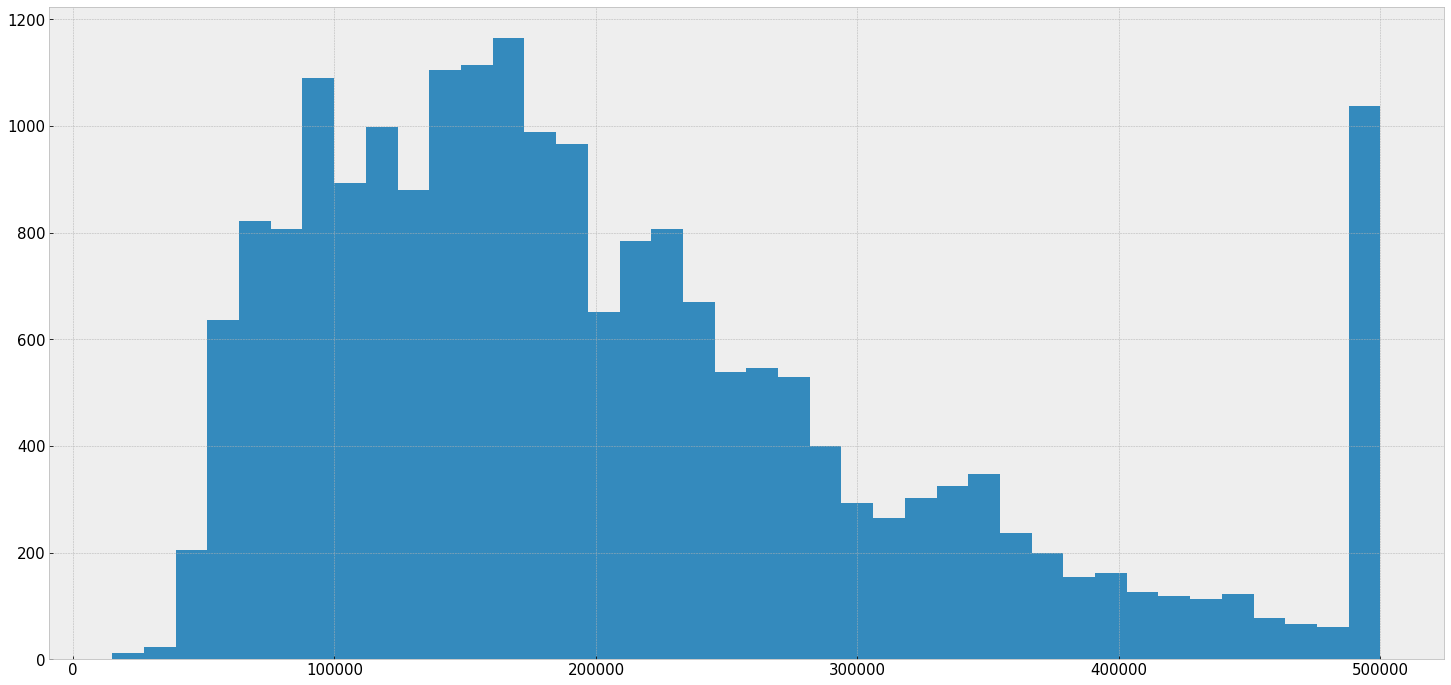

In [33]:
plt.hist( df4 ['median_house_value'], bins= 40);

### 4.1.2. Numerical veriable

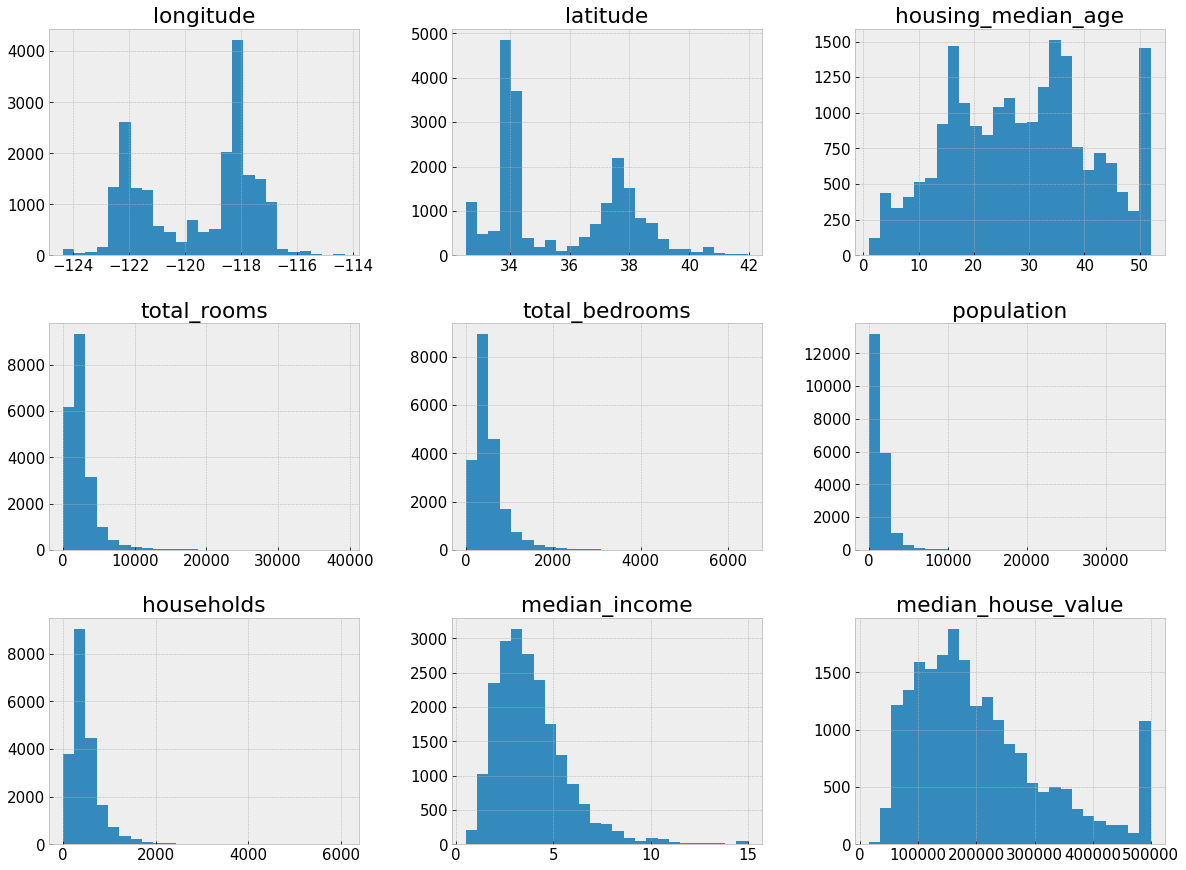

In [34]:
num_attributes.hist(bins=25, figsize=(20, 15));

### 4.1.3. Categorical veriable

In [36]:
df4['ocean_proximity'].drop_duplicates()

0         NEAR BAY
701      <1H OCEAN
954         INLAND
1850    NEAR OCEAN
8314        ISLAND
Name: ocean_proximity, dtype: object

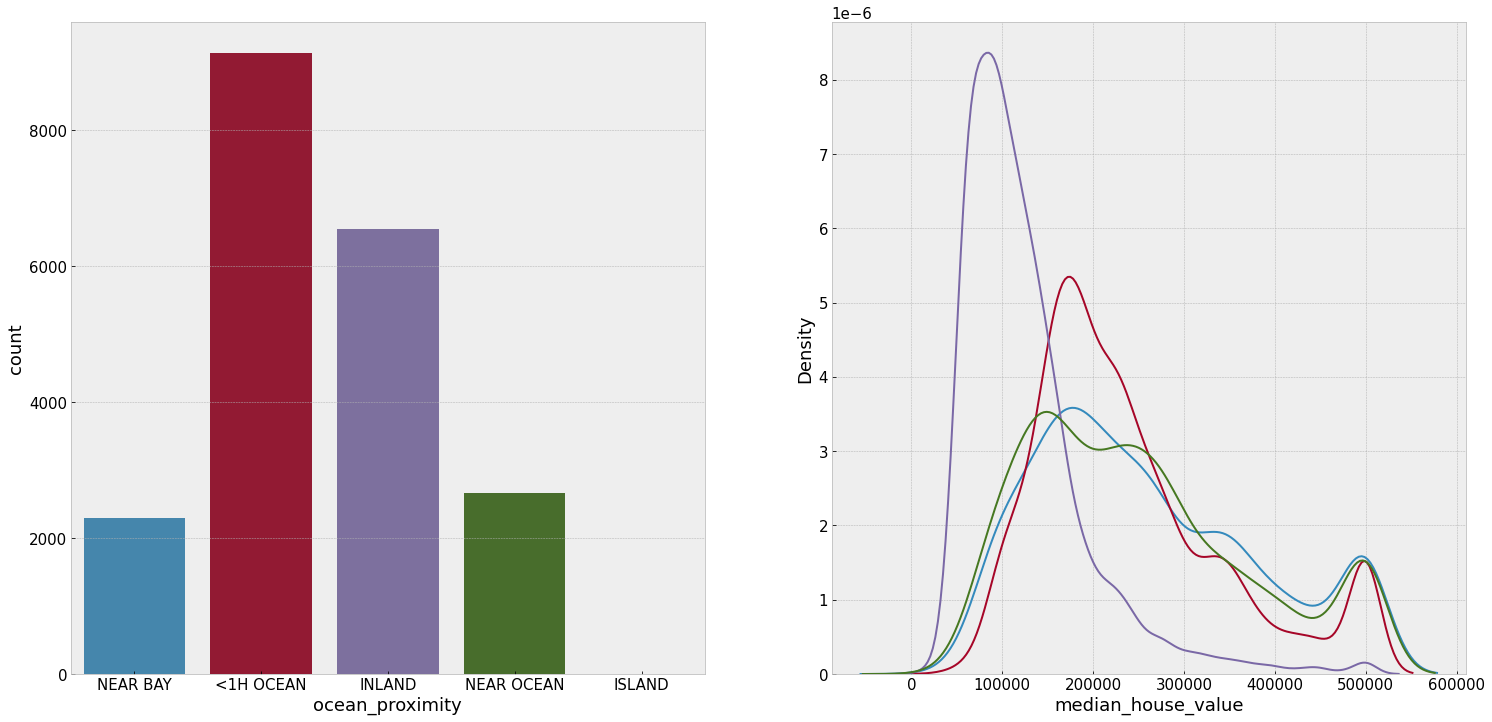

In [208]:
plt.subplot( 1, 2, 1 )
sns.countplot(x='ocean_proximity', data=df4);

plt.subplot( 1, 2, 2 )
sns.kdeplot( df4[df4['ocean_proximity'] == 'NEAR BAY'] ['median_house_value'], label = 'near bay' );
sns.kdeplot( df4[df4['ocean_proximity'] == '<1H OCEAN'] ['median_house_value'], label = '<1h ocean' );
sns.kdeplot( df4[df4['ocean_proximity'] == 'INLAND'] ['median_house_value'], label = 'inland' );
sns.kdeplot( df4[df4['ocean_proximity'] == 'NEAR OCEAN'] ['median_house_value'], label = 'near ocean' );

## 4.2. Análise bivariada

### h1. Clientes com maior renda compram imóveis mais caros
**FALSA:** Clientes com maior renda compram imóveis mais baaratos

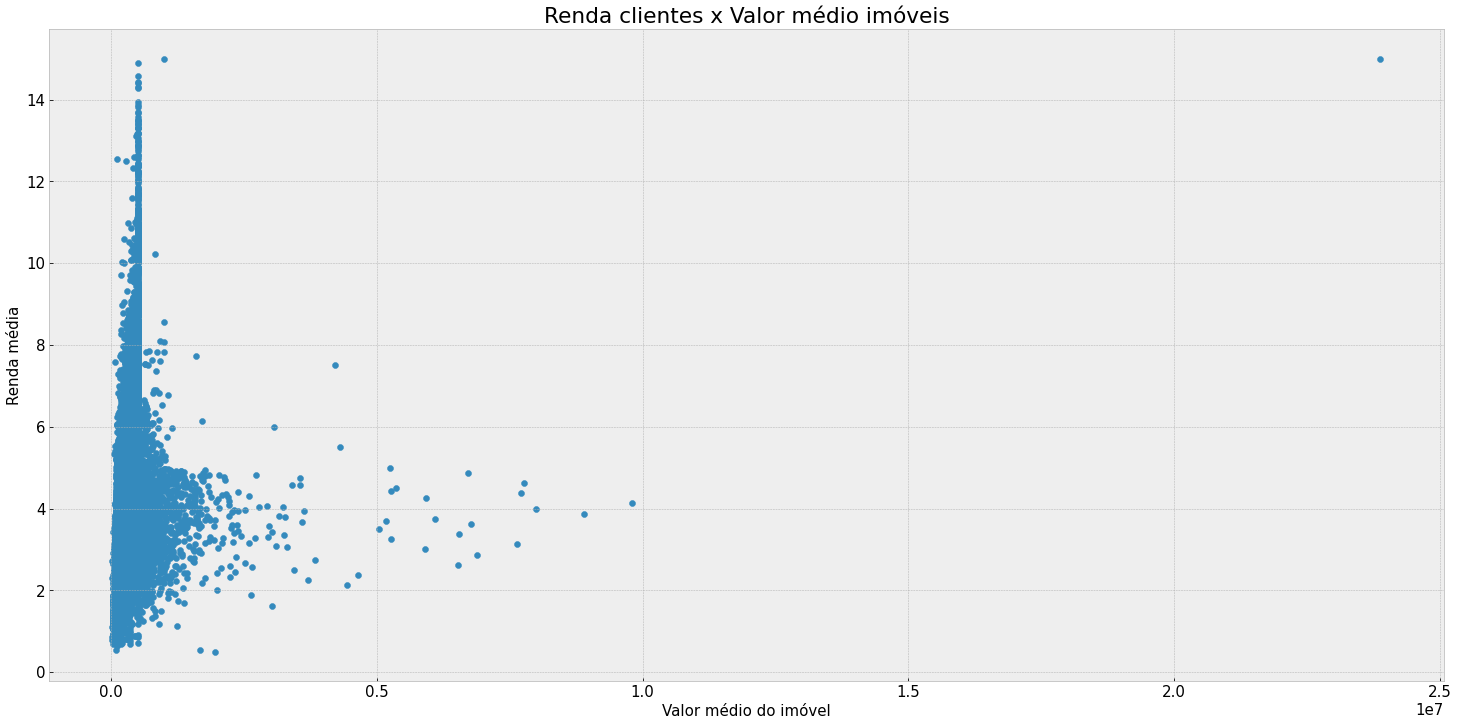

In [140]:
aux = df4[['median_income', 'median_house_value']].groupby('median_income').sum().reset_index()
aux1 = aux.sort_values('median_income', ascending=False)

plt.scatter( aux1['median_house_value'], aux1['median_income'] );
plt.xlabel('Valor médio do imóvel', size = 15);
plt.ylabel('Renda média', size = 15);
plt.title('Renda clientes x Valor médio imóveis');

### h2. Clientes com maiores famílias compram imóveis mais baratos
**VERDADEIRA:** Clientes com maiores famílias compram imóveis mais baratos

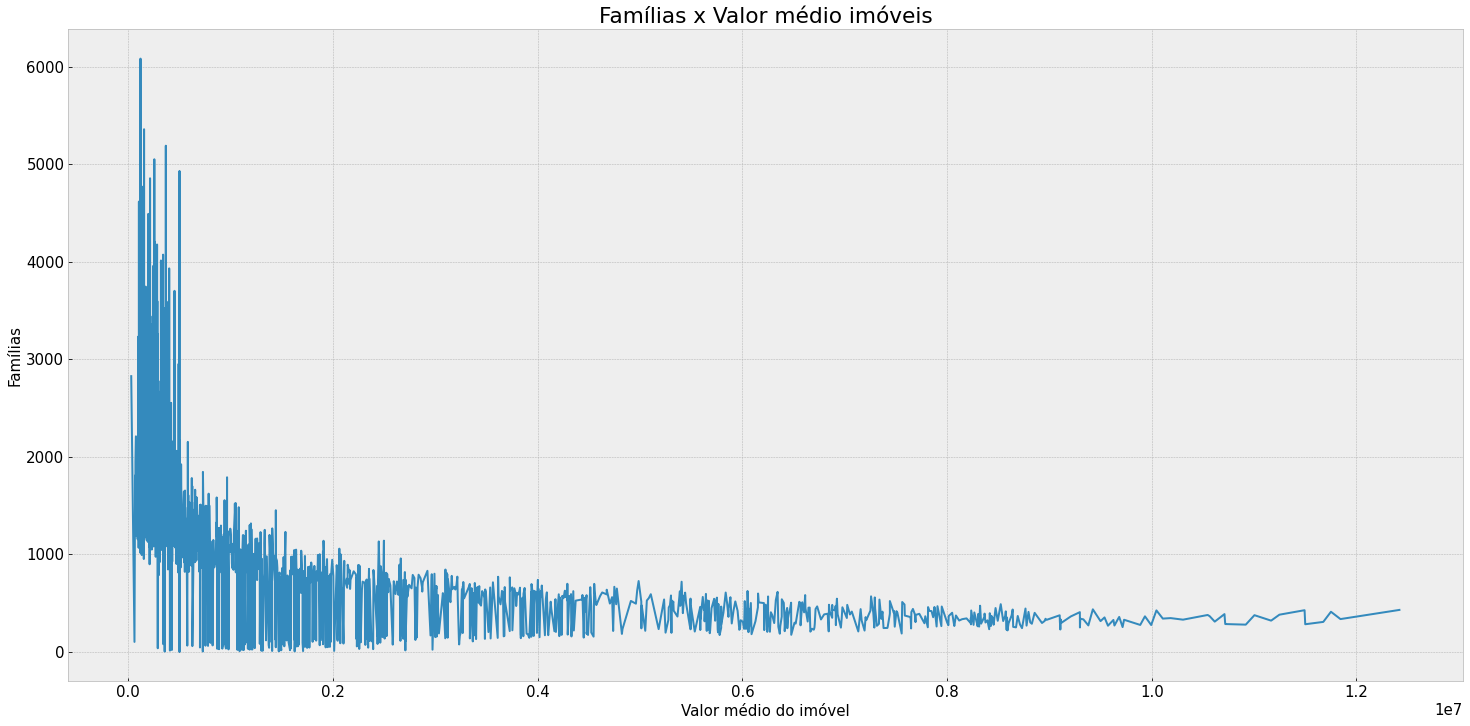

In [154]:
aux2 = df4[['households', 'median_house_value']].groupby('households').sum().reset_index()
aux2 = aux2.sort_values('median_house_value', ascending=False)

plt.plot( aux2['median_house_value'], aux2['households'] );
plt.xlabel('Valor médio do imóvel', size = 15);
plt.ylabel('Famílias', size = 15);
plt.title('Famílias x Valor médio imóveis');

### h3. Clientes com maior renda compram imóveis mais novos
**VERDADEIRA:** Clientes com maior renda compram imóveis mais novos

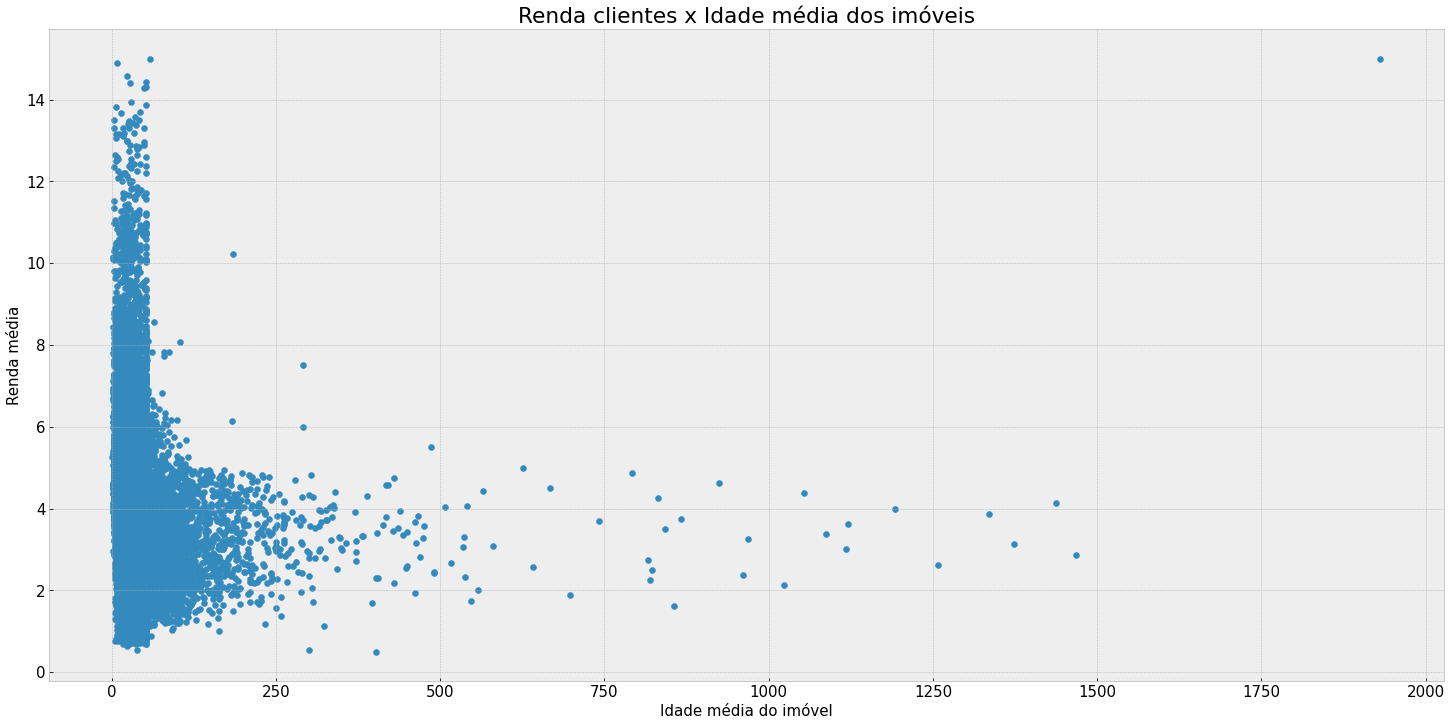

In [160]:
aux3 = df4[['median_income', 'housing_median_age']].groupby('median_income').sum().reset_index()
aux3 = aux3.sort_values('median_income', ascending=False)

plt.scatter( aux3['housing_median_age'], aux3['median_income'] );
plt.xlabel('Idade média do imóvel', size = 15);
plt.ylabel('Renda média', size = 15);
plt.title('Renda clientes x Idade média dos imóveis');

### h4. Clientes com menor renda compram mais antigos
**FALSA:** Não necessariamente

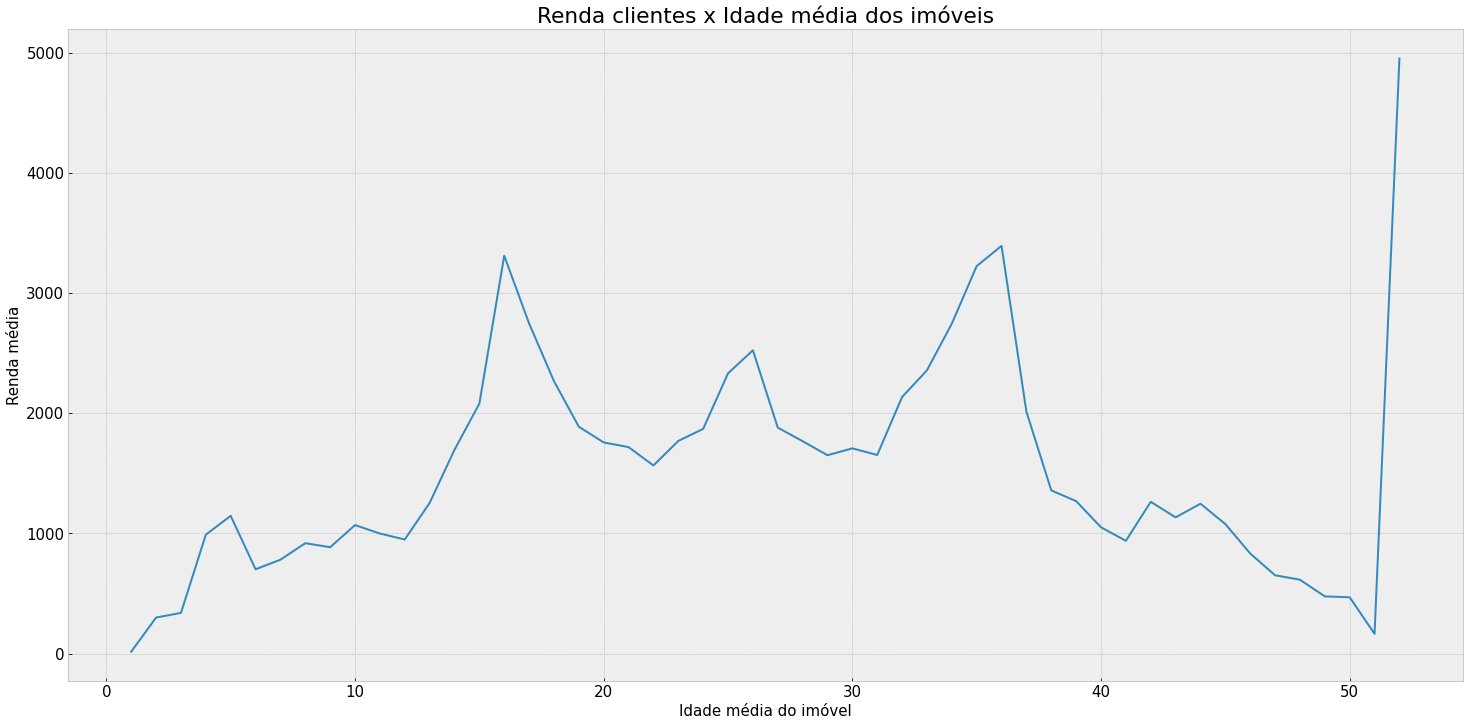

In [178]:
aux4 = df4[['housing_median_age', 'median_income']].groupby('housing_median_age').sum().reset_index()
aux4 = aux4.sort_values('housing_median_age', ascending=False)

plt.plot( aux4['housing_median_age'], aux4['median_income'] );
plt.xlabel('Idade média do imóvel', size = 15);
plt.ylabel('Renda média', size = 15);
plt.title('Renda clientes x Idade média dos imóveis');

### h5. Imóveis localizados em ilhas são costumam ser mais caros
**FALSA:** Imóveis localizados à 1h de distância do oceano são os mais caros

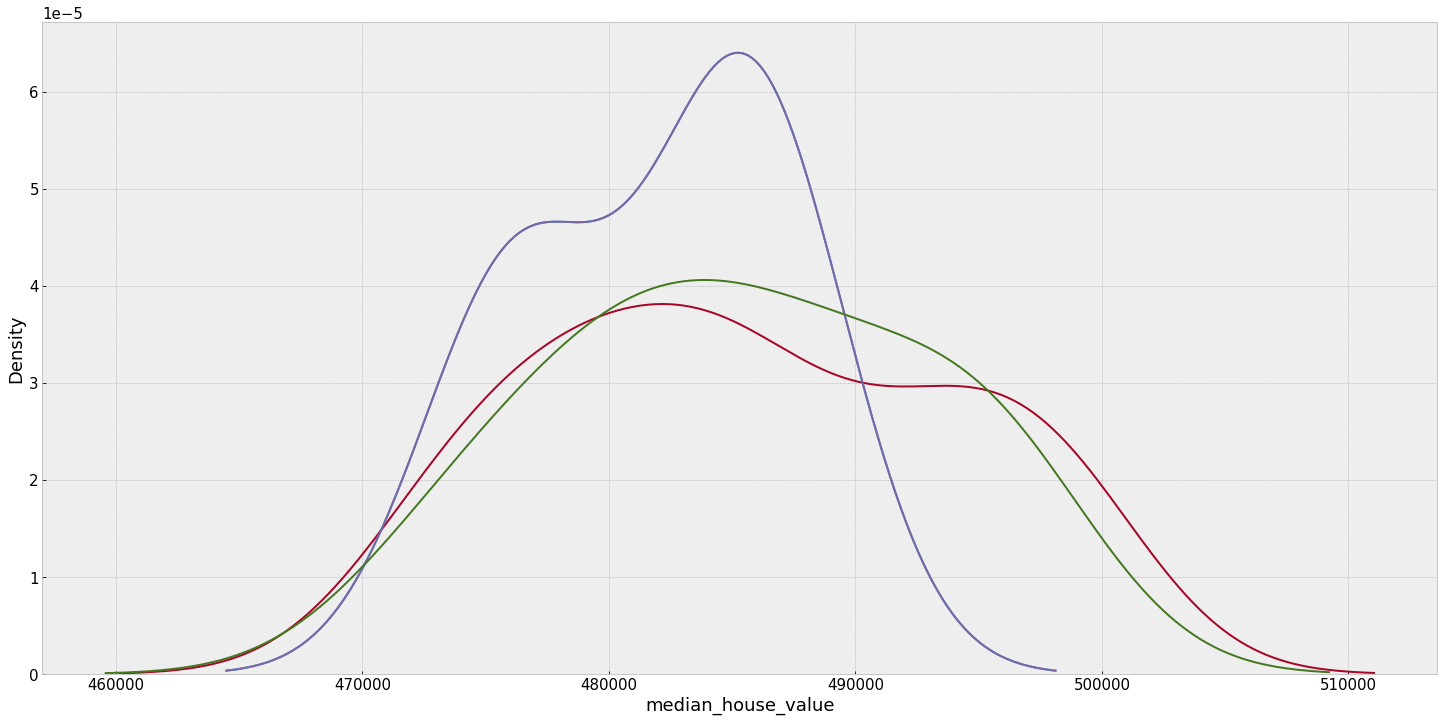

In [251]:
aux = df4[['ocean_proximity', 'median_house_value']].groupby('median_house_value').sum().reset_index()
aux5 = aux.sort_values('median_house_value', ascending=False).head(100)


sns.kdeplot( aux5[aux5['ocean_proximity'] == 'INLAND'] ['median_house_value'], label = 'inland' );
sns.kdeplot( aux5[aux5['ocean_proximity'] == '<1H OCEAN'] ['median_house_value'], label = '<1h ocean' );
sns.kdeplot( aux5[aux5['ocean_proximity'] == 'INLAND'] ['median_house_value'], label = 'inland' );
sns.kdeplot( aux5[aux5['ocean_proximity'] == 'NEAR OCEAN'] ['median_house_value'], label = 'near ocean' );

### h6. Imóveis localizados no interior são mais baratos

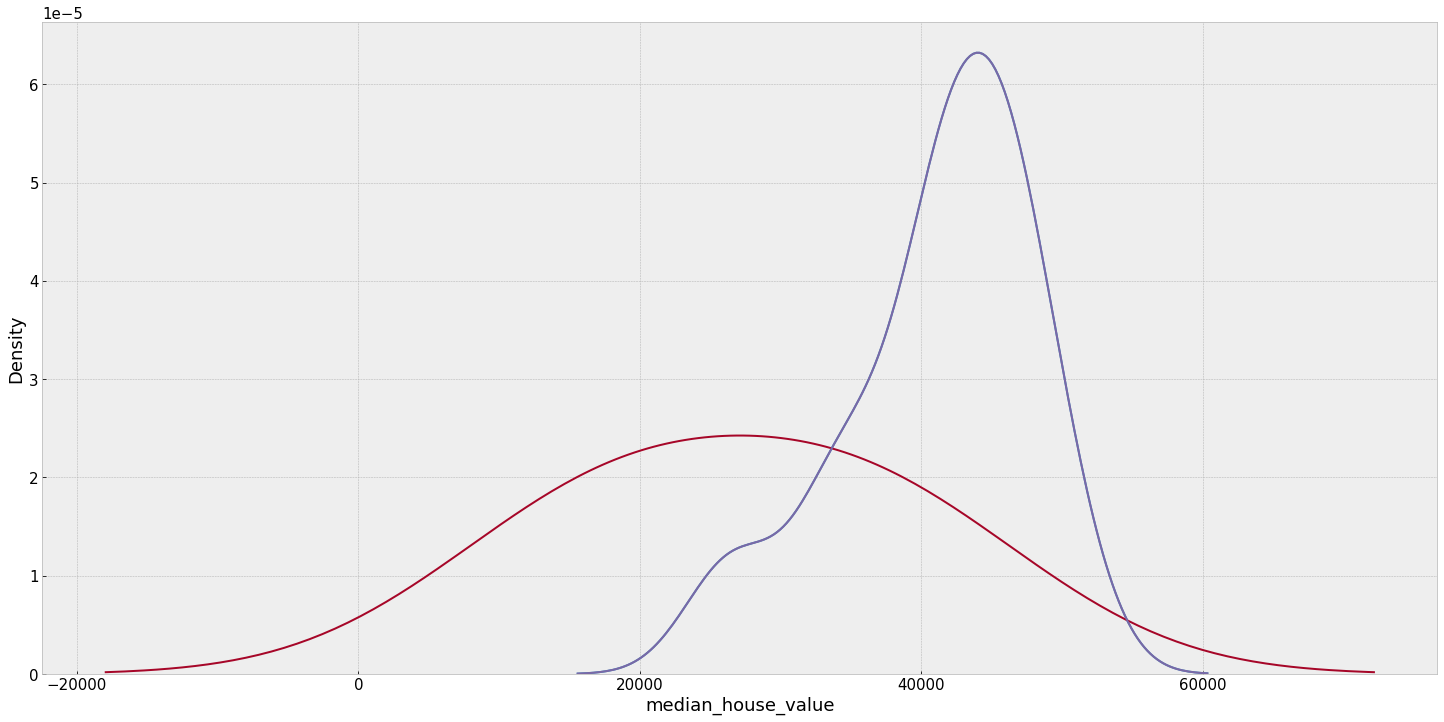

In [254]:
aux = df4[['ocean_proximity', 'median_house_value']].groupby('median_house_value').sum().reset_index()
aux5 = aux.sort_values('median_house_value', ascending=True).head(100)

sns.kdeplot( aux5[aux5['ocean_proximity'] == 'INLAND'] ['median_house_value'], label = 'inland' );
sns.kdeplot( aux5[aux5['ocean_proximity'] == '<1H OCEAN'] ['median_house_value'], label = '<1h ocean' );
sns.kdeplot( aux5[aux5['ocean_proximity'] == 'INLAND'] ['median_house_value'], label = 'inland' );
sns.kdeplot( aux5[aux5['ocean_proximity'] == 'NEAR OCEAN'] ['median_house_value'], label = 'near ocean' );

## 4.3. Análise multivariada

### 4.3.1.  Numerical Attributes

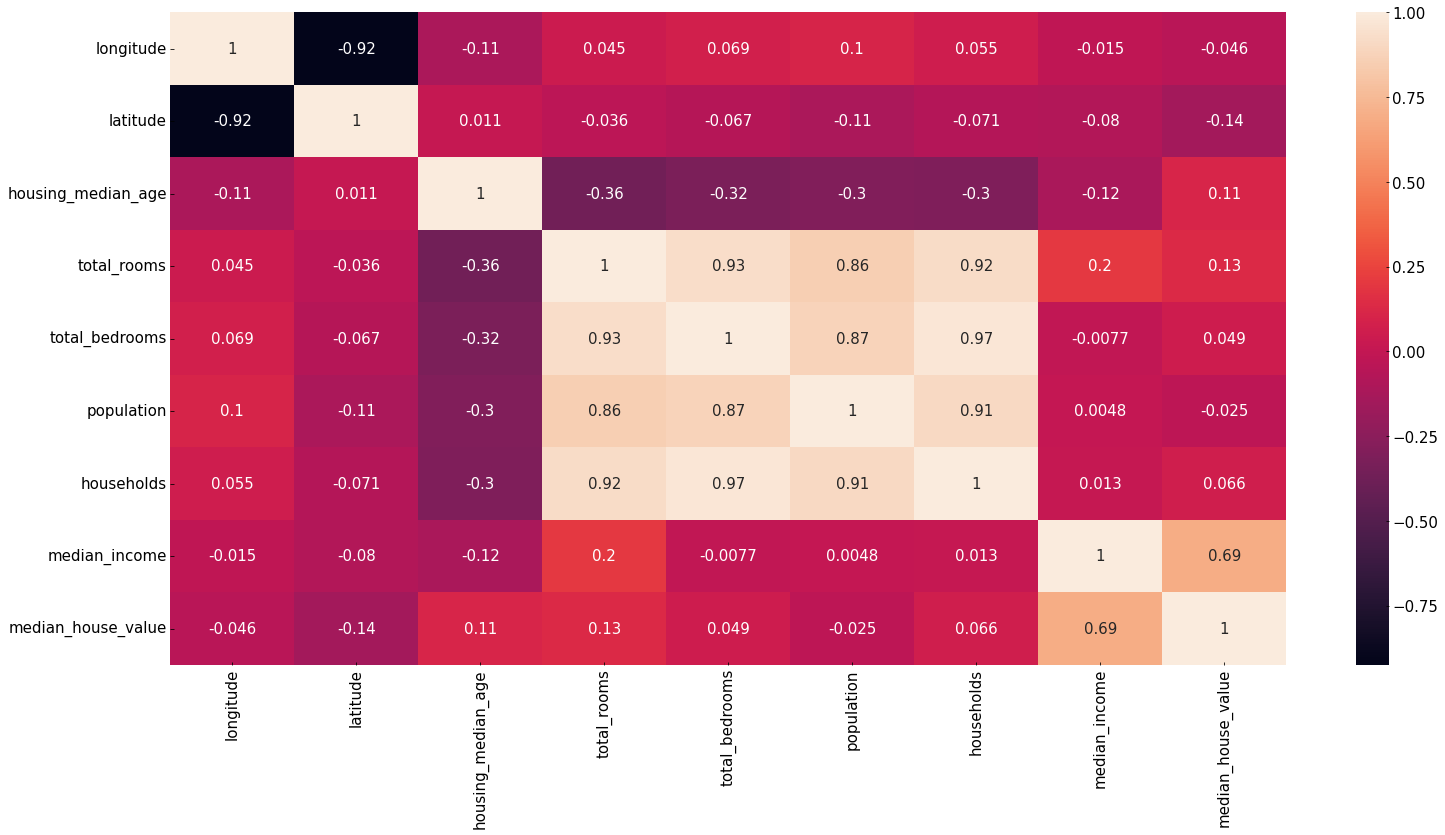

In [255]:
correlation = num_attributes.corr(method= 'pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2.  Categorical Attributes

In [256]:
cat_attributes.head()

,ocean_proximity
0,NEAR BAY
1,NEAR BAY
2,NEAR BAY
3,NEAR BAY
4,NEAR BAY


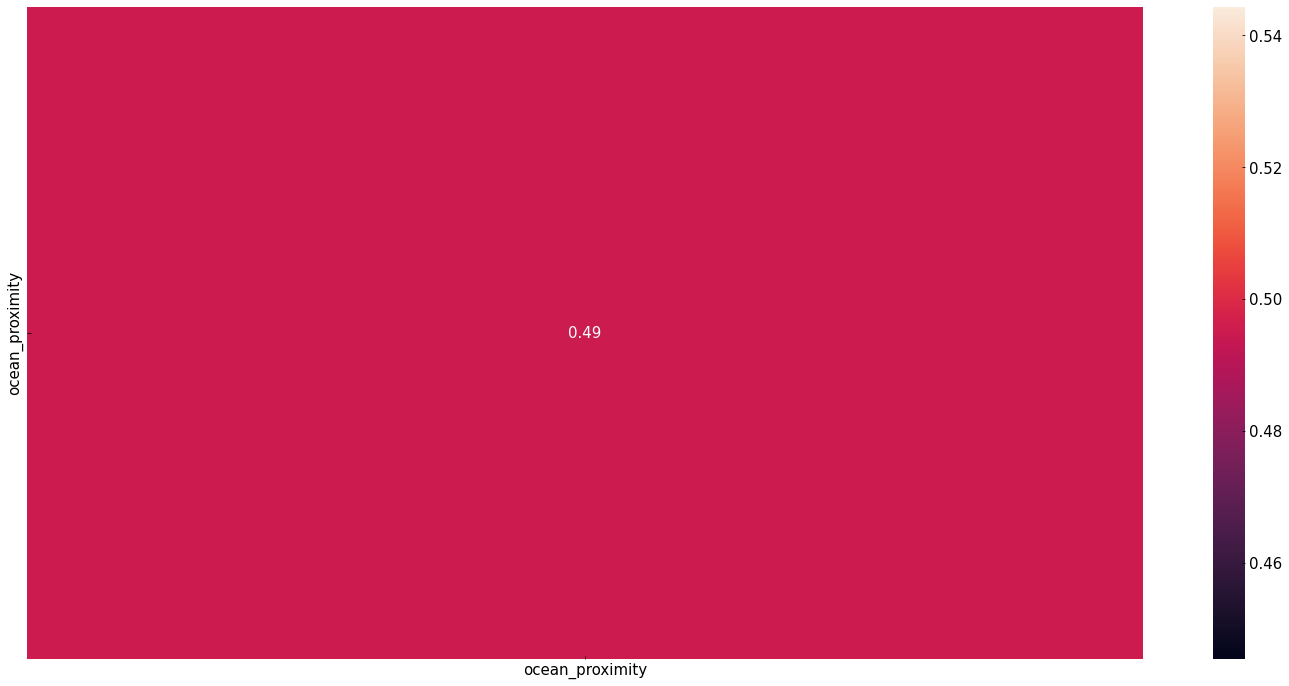

In [280]:
 # only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['ocean_proximity'], df4['median_house_value'] )
cm = pd.crosstab(a['ocean_proximity'], df4['median_house_value'])

# Final dataset
d = pd.DataFrame( {'ocean_proximity': [a1] } )

d = d.set_index( d.columns )
sns.heatmap( d, annot=True );

# 5.0. DATA PREPARATION 